In [120]:
%less ./data/jacoco.csv

In [30]:
import pandas as pd

coverage = pd.read_csv("./data/jacoco.csv")[['PACKAGE', 'CLASS', 'LINE_COVERED', 'LINE_MISSED']]
coverage.head()

,PACKAGE,CLASS,LINE_COVERED,LINE_MISSED
0,org.springframework.samples.petclinic,PetclinicInitializer,24,0
1,org.springframework.samples.petclinic.model,NamedEntity,4,1
2,org.springframework.samples.petclinic.model,Specialty,1,0
3,org.springframework.samples.petclinic.model,PetType,1,0
4,org.springframework.samples.petclinic.model,Vets,0,4


In [36]:
coverage['lines'] = coverage.LINE_COVERED + coverage.LINE_MISSED
coverage['coverage'] = coverage.LINE_COVERED / coverage.lines
coverage.head()

,PACKAGE,CLASS,LINE_COVERED,LINE_MISSED,lines,coverage
0,org.springframework.samples.petclinic,PetclinicInitializer,24,0,24,1.0
1,org.springframework.samples.petclinic.model,NamedEntity,4,1,5,0.8
2,org.springframework.samples.petclinic.model,Specialty,1,0,1,1.0
3,org.springframework.samples.petclinic.model,PetType,1,0,1,1.0
4,org.springframework.samples.petclinic.model,Vets,0,4,4,0.0


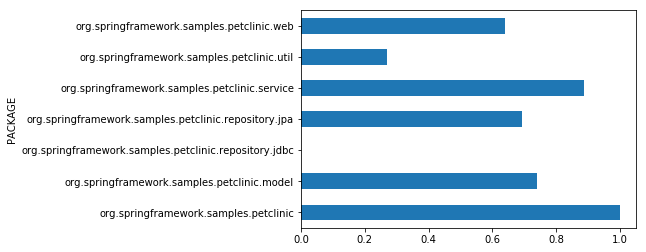

In [40]:
%matplotlib inline

coverage.groupby("PACKAGE").mean()['coverage'].plot(kind='barh')

In [43]:
coverage['fqn'] = coverage.PACKAGE + "." + coverage.CLASS
coverage[['fqn', 'lines']].head()

,fqn,lines
0,org.springframework.samples.petclinic.Petclini...,24
1,org.springframework.samples.petclinic.model.Na...,5
2,org.springframework.samples.petclinic.model.Sp...,1
3,org.springframework.samples.petclinic.model.Pe...,1
4,org.springframework.samples.petclinic.model.Vets,4


In [44]:
import py2neo

graph = py2neo.Graph()

query="""
MATCH 
  (p:Package)-[:CONTAINS]->(c:Class)<-[DEPENDS_ON]-(c2:Class)<-[:CONTAINS]-(p2:Package)
WHERE p.fqn = "org.springframework.samples.petclinic.repository.jdbc" AND p <> p2
RETURN DISTINCT c.fqn, c2.fqn
"""

graph.data(query)

[{'c.fqn': 'org.springframework.samples.petclinic.repository.jdbc.JdbcVetRepositoryImpl',
  'c2.fqn': 'org.springframework.samples.petclinic.service.ClinicServiceImpl'},
 {'c.fqn': 'org.springframework.samples.petclinic.repository.jdbc.JdbcVisitRepositoryImpl',
  'c2.fqn': 'org.springframework.samples.petclinic.service.ClinicServiceImpl'},
 {'c.fqn': 'org.springframework.samples.petclinic.repository.jdbc.JdbcPetRepositoryImpl',
  'c2.fqn': 'org.springframework.samples.petclinic.service.ClinicServiceImpl'},
 {'c.fqn': 'org.springframework.samples.petclinic.repository.jdbc.JdbcOwnerRepositoryImpl',
  'c2.fqn': 'org.springframework.samples.petclinic.service.ClinicServiceImpl'}]

Laden der Coverage-Informationen in die Graphdatenbank

In [51]:
query="""
    UNWIND {coverage_data} as coverage
    MATCH (c:Class)
    WHERE c.fqn = coverage.fqn
    MERGE (c)-[:HAS_MEASURE]->(m)
    SET 
        m:Measure:Coverage, 
        m.lineCoverage = coverage.coverage
        
    RETURN c.fqn, m.lineCoverage
"""

result = graph.run(query, coverage_data=coverage.to_dict(orient='records')).data()
pd.DataFrame(result).head()

,c.fqn,m.lineCoverage
0,org.springframework.samples.petclinic.Petclini...,1.0
1,org.springframework.samples.petclinic.model.Na...,0.8
2,org.springframework.samples.petclinic.model.Sp...,1.0
3,org.springframework.samples.petclinic.model.Pe...,1.0
4,org.springframework.samples.petclinic.model.Vets,0.0


In [53]:
query = """
MATCH 
  (n:Subdomain)
    <-[:BELONGS_TO]-
      (c:Class)
        -[:HAS_MEASURE]->
          (m:Coverage) 
RETURN n.name as subdomain,  AVG(m.lineCoverage) as covered_lines
ORDER BY covered_lines
"""
pd.DataFrame(graph.data(query), columns=['subdomain','covered_lines'])

,subdomain,covered_lines
0,Vet,0.176667
1,Visit,0.385417
2,Pet,0.540142
3,Owner,0.549495
4,Clinic,0.888889
5,Person,1.000000
6,Specialty,1.000000


Identifying code to delete

In [21]:
query="""
MATCH
    (s1:Subdomain)<-[:BELONGS_TO]-
    (type:Type)-[r:DEPENDS_ON*0..1]->
    (dependency:Type)-[:BELONGS_TO]->(s2:Subdomain),
    (type)-[:HAS_MEASURE]->(c:Coverage)
RETURN s1.name as from, s2.name as to, SUM(c.value) as x_number
"""
result = graph.run(query).data()
df = pd.DataFrame(result)
df.head()

,from,to,x_number
0,Clinic,Visit,32
1,Clinic,Clinic,16
2,Visit,Visit,21
3,Clinic,Vet,32
4,Owner,Pet,26


In [22]:
import json
json_data = df.to_dict(orient='split')['data']
with open ( "vis/chord_deletion_data.json", mode='w') as json_file:
    json_file.write(json.dumps(json_data, indent=3))
json_data[:5]

[['Clinic', 'Visit', 32],
 ['Clinic', 'Clinic', 16],
 ['Visit', 'Visit', 21],
 ['Clinic', 'Vet', 32],
 ['Owner', 'Pet', 26]]

# Quick Wins
Einige Klassen können bedenkenfrei gelöscht werden

In [ ]:
query="""
MATCH (p:Package)-[:CONTAINS]->(c:Class)<-[:DEPENDS_ON]-(d:Class),
(d)<-[:CONTAINS]-(p2),
(c)-[:HAS_MEASURE]->(m:Measure:Coverage)
WITH p, c,  SUM(m.value) as lines
WHERE lines = 0
RETURN c.name as _zu_loeschen, c.fqn, p.fqn
"""

pd.DataFrame(graph.data(query))